# Image Denoising With Gibbs Sampling

In this exercise you will implement image denoising with Gibbs sampling on an Ising model.

For reading image files, this code requires the Python Pillow package.

The following cell provides some useful functionality.

In [505]:
from PIL import Image           # pillow
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import default_rng
rng = default_rng()


def readImg(imgname):
    img = np.asarray(Image.open(imgname + '.png'), dtype=np.float64)[:,:,0]
    off = (np.max(img) - np.min(img)) / 2
    img -= off
    img /= off
    return img  # matrix containing values -1 and 1


def perturbNormal(img, sigma):
    return img + rng.normal(size=img.shape, scale=sigma)

def perturbFlip(img, frac):
    imgNoisy = np.copy(img)
    imgNoisy[rng.uniform(0, 1, size=img.shape) < frac] *= -1
    return imgNoisy


def showImg(img):
    plt.imshow(img, cmap='gray')

def showImgs(clean, noisy):
    fig, (axClean, axNoisy) = plt.subplots(1,2)
    axClean.imshow(clean, cmap='gray')
    axClean.set_title=('Clean Image')
    axNoisy.imshow(noisy, cmap='gray')
    axNoisy.set_title=('Noisy Image')

Create and display your noisy image here:

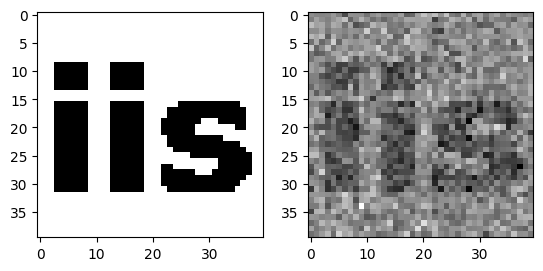

In [478]:
img = readImg('iis')                          # also try other images
if True:                                      # set to True or False to choose your noise
    imgNoisy = perturbNormal(img, 1)          # 2nd arg is standard deviation of noise
else:
    imgNoisy = perturbFlip(img, 0.2)          # 2nd arg is proportion of flipped pixels
    
showImgs(img, imgNoisy)

Implement your solution in the following code block.

In our specific Ising model,
$$p(\mathbf{z}) = \frac{1}{Z_0} \exp\left(\sum_i \sum_{j\in\textrm{nbr}(i)} z_i z_j\right)$$
The linking matrix $W_{i j}$ is all ones and can thus be omitted.

In the Gaussian likelihood function
$$
\begin{array}{rcl}
p(\mathbf{x}|\mathbf{z}) &=& \displaystyle \prod_i \exp(\ell_i(z_i)) \\
\ell_i(z_i) &=& \displaystyle -\frac{1}{2\sigma^2} (x_i - z_i)^2 \;=\; \log p(x_i|z_i) + Z_1
\end{array}
$$
the normalization factor $Z_1$ can be disregarded because it will cancel in the update rule. The value of $\sigma$ is a model parameter that is to be passed to the function `denoise()`.

In [533]:
# Returns a denoised version of the nparray img using Gibbs sampling and metadata.
# img is a noisy version of a binary image; true pixel states are -1 or 1.
# sigma is the standard deviation of the normal distribution governing the likelihood function p(x|z).
# nBurnIn is the number of instances that are dropped at the beginning of the Markov chain.
# nDrop is 1 + the number of instances that are dropped between used instances,
#       i.e., one in nDrop instances is used, the others are dropped.
# nAvg is the number of (used) instances that are averaged to obtain the final result.

def denoiseGibbs(img, sigma, nBurnIn, nDrop, nAvg):
    # reused the code form hw01 (icm.ipynb)
    img_denoised = np.ones_like(img)
    img_denoised[img < 0] = -1

    # reused likelihood calculation from hw02 (meanfield.ipynb)
    l_plus_arr = -(1 / (2 * sigma ** 2)) * (img - 1) ** 2
    l_minus_arr = -(1 / (2 * sigma ** 2)) * (img + 1) ** 2
    l_diff_arr = (l_plus_arr - l_minus_arr)

    img_denoised_sum = np.zeros_like(img_denoised)
    total_iters = nBurnIn + nDrop * nAvg
    num_updates = 0
    for iter in range(total_iters):
        update_gibbs(img_denoised, l_diff_arr)

        if iter >= nBurnIn and iter % nDrop == 0:
            img_denoised_sum += img_denoised
            num_updates += 1

    img_denoised_avg = img_denoised_sum / nAvg
    img_denoised_avg[img_denoised_sum >= 0] = 1
    img_denoised_avg[img_denoised_sum < 0] = -1
    return img_denoised_avg, sigma, nBurnIn, nDrop, nAvg, total_iters, num_updates

def update_gibbs(img_denoised, l_diff_arr):
    height, width = img_denoised.shape
    for i in range(height):
        for j in range(width):
            # calculate neighbor influence on img_denoised[i, j] (code from hw02)
            m_ij = 0
            neighbors = [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
            for n_i, n_j in neighbors:
                if 0 <= n_i < height and 0 <= n_j < width:
                    m_ij += img_denoised[n_i, n_j]
            
            # calculate p(z_i = +1 | z_-i, x) (from slide 22)
            prob_z_plus = sigmoid(2 * m_ij + l_diff_arr[i, j])
            random_value = np.random.uniform()
            img_denoised[i, j] = +1 if random_value < prob_z_plus else -1

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


Now test your code:

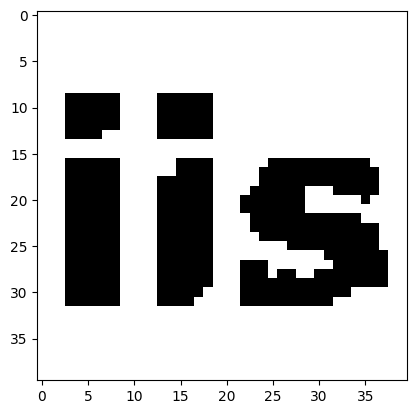

In [507]:
result = denoiseGibbs(imgNoisy, 1, 100, 10, 10)
showImg(result[0])

Play with different versions of the parameters. Explain your observations below, including illustrations generated with `showImg(imgDenoised)`.

## My Observations

In [510]:
def run_experiment(imgNoisy, sigmas, nBurnIns, nDrops, nAvgs):
    # I fixed the seed for a better comparison with different versions of parameters 
    np.random.seed(12345)
    imgs = []
    for sigma, nBurnIn, nDrop, nAvg in zip(sigmas, nBurnIns, nDrops, nAvgs):
        imgs.append(denoiseGibbs(imgNoisy, sigma, nBurnIn, nDrop, nAvg))
    show_experiment(*imgs)

def show_experiment(*tuples, cmap='gray'):
    n = len(tuples)
    fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))

    if n == 1:
        axes = [axes]

    for ax, data in zip(axes, tuples):
        if isinstance(data, tuple) and len(data) == 7:
            img, sigma, nBurnIn, nDrop, nAvg, total_iters, num_updates = data
            caption = f"sigma={sigma}, nBurnIn={nBurnIn}, nDrop={nDrop}\nnAvg={nAvg}, iters={total_iters}, updates={num_updates}"
        else:
            raise ValueError("Each argument must be a tuple: (img, sigma, nBurnIn, nDrop, nAvg, total_iters, num_updates)")

        ax.imshow(img, cmap=cmap)
        ax.text(
            0.5, -0.2, caption,
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=8
        )

    plt.subplots_adjust(bottom=0.3)
    plt.show()

In the following, I played with different versions of `nBurnIn`, `nDrop` and `nAvg`:

For the first row, I set `nBurnIn = 0` and `nDrop = 1` which means every Gibbs sample is used in the final result. This ignores the fact that Gibbs samples are autocorrelated (as mentioned on slide 22). It also means that `nAvg` equals the total number of iterations. For the second and third row, I set `nBurnIn = 10` and `nBurnIn = 100`, respectively. This means that the first 10 or 100 samples are discarded before the first update. In the fourth and fifth row, I instead set `nDrop = 5` and `nDrop = 10`, respectively. This results in keeping only every 5th or 10th sample and tries to handle the autocorrelation between samples. Finally, in the last row, I set both `nBurnIn = 100` and `nDrop = 10` to demonstrate the effect of combining both strategies.

As we see from the results below, different configurations of `nBurnIn` and `nDrop` lead to different results, especially in early updates (1-10). Between 10 and 100 updates, the results become more similar due to convergence. The first row appears to be the most 'noisy' result. When discarding the first 10 samples with `nBurnIn = 10` in the second row, we observe an improvement in the early updates, which gets even better in the third row with `nBurnIn = 100`. The effects of `nDrop = 5` and `nDrop = 10` are also visible and lead to more meaningful updates. To summarize, we cannot definitively say which configuration produces the best result. Overall, all versions produce a fairly good result in the end, though the configurations with burn-ins and drop-outs perform slightly better.

ignore autocorrelation -> set nBurnIn = 0 and nDrop = 1 => nAvg determines number of iterations


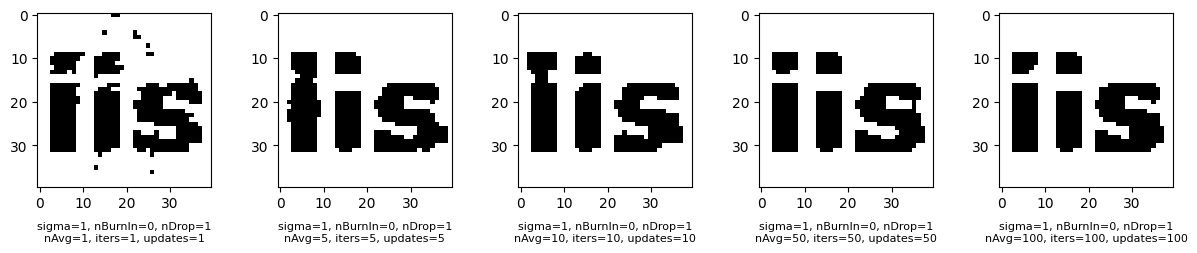

introduce only nBurnIn = 10


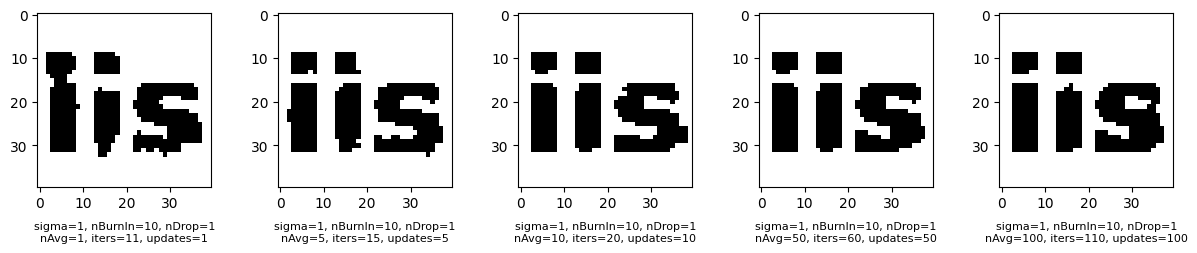

increase only nBurnIn = 100


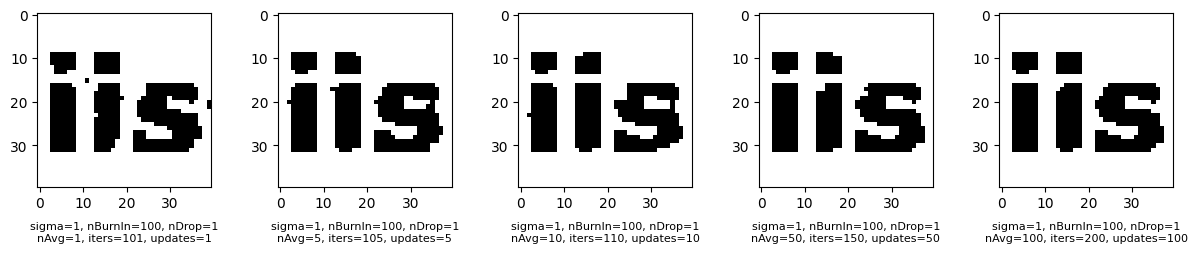

introduce only nDrop = 5


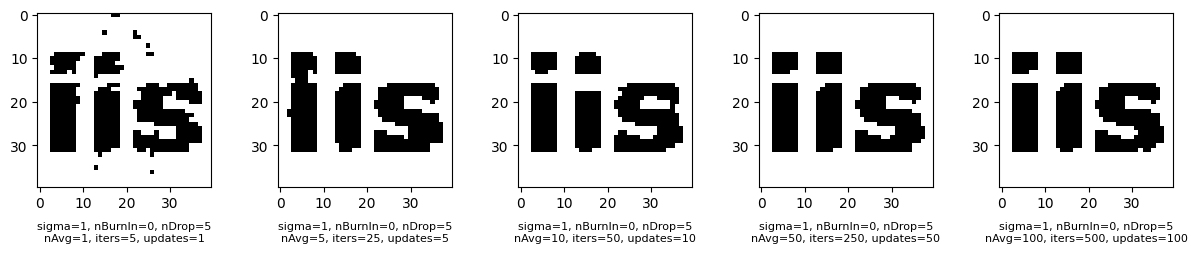

increase only nDrop = 10


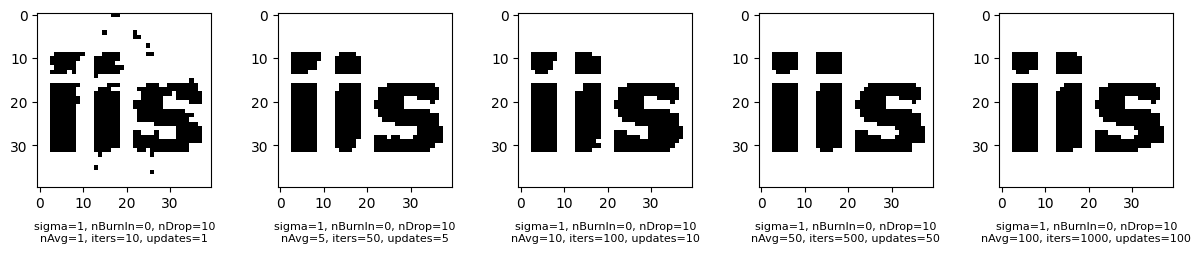

do both: nBurnIn = 100, nDrop = 10


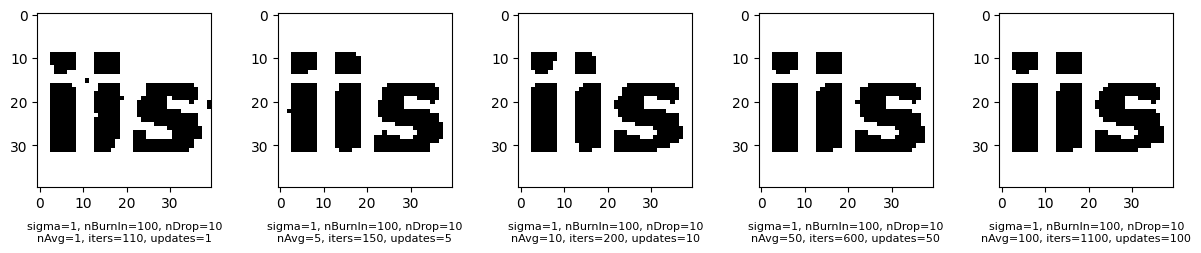

In [517]:
print("ignore autocorrelation -> set nBurnIn = 0 and nDrop = 1 => nAvg determines number of iterations")
run_experiment(imgNoisy, sigmas=[1]*5, nBurnIns=[0]*5, nDrops=[1]*5, nAvgs=[1, 5, 10, 50, 100])
print("introduce only nBurnIn = 10")
run_experiment(imgNoisy, sigmas=[1]*5, nBurnIns=[10]*5, nDrops=[1]*5, nAvgs=[1, 5, 10, 50, 100])
print("increase only nBurnIn = 100")
run_experiment(imgNoisy, sigmas=[1]*5, nBurnIns=[100]*5, nDrops=[1]*5, nAvgs=[1, 5, 10, 50, 100])
print("introduce only nDrop = 5")
run_experiment(imgNoisy, sigmas=[1]*5, nBurnIns=[0]*5, nDrops=[5]*5, nAvgs=[1, 5, 10, 50, 100])
print("increase only nDrop = 10")
run_experiment(imgNoisy, sigmas=[1]*5, nBurnIns=[0]*5, nDrops=[10]*5, nAvgs=[1, 5, 10, 50, 100])
print("do both: nBurnIn = 100, nDrop = 10")
run_experiment(imgNoisy, sigmas=[1]*5, nBurnIns=[100]*5, nDrops=[10]*5, nAvgs=[1, 5, 10, 50, 100])

In the following, I played with different configurations for `sigma`:

I set `sigma = [0.25, 0.5, 0.75, 1, 1.25, 1.5]` while keeping `nBurnIn = 0`, `nDrops = 1` and `nAvgs = [1, 5, 10, 50, 100]`. I choose this setup to isolate the effect of `sigma`, since burn-ins and drop-outs spread the updates accross iterations and therefore require more iterations for the same amount of updates. This makes it harder to clearly observe the specific influence of sigma.

Recall the Gaussian likelihood function (copied from above)
$$
\begin{array}{rcl}
p(\mathbf{x}|\mathbf{z}) &=& \displaystyle \prod_i \exp(\ell_i(z_i)) \\
\ell_i(z_i) &=& \displaystyle -\frac{1}{2\sigma^2} (x_i - z_i)^2 \;=\; \log p(x_i|z_i) + Z_1
\end{array}
$$

`sigma` is only relevant within the likelihood function. If `sigma` is small this leads to a larger likelihood and if it is large this leads to a smaller one. This is also exactly what we see in the results below.

When `sigma` is low (0.25 and 0.5), the value passed to the sigmoid function becomes a large positive or negative number, resulting in extremely high or low probabilities for the new image value to be positive. As a result, the random component has little influence on the outcome. Instead, the noisy pixel value dominates due to the strong likelihood. Therefore, the noisy image does not really change and stays noisy.

Exactly the oposite happens if `sigma` is higher (1.25, 1.5). The sigmoid values are not that extreme anymore and therefore the sampling becomes more influenced by the prior of the Ising model, which encourages neighboring pixels to take similar values and with these values for sigma leads to bad results.

Exactly the opposite happens when `sigma` is higher (1.25, 1.5). The sigmoid values are no longer extreme, making the sampling more influenced by the prior of the Ising model, which encourages neighboring pixels to take similar values. With these larger `sigma` values, this results in oversmoothing and leads to poorer reconstruction quality.

As the results show, a `sigma` of 0.75 or 1 seems to be the right balance between noise and prior information.

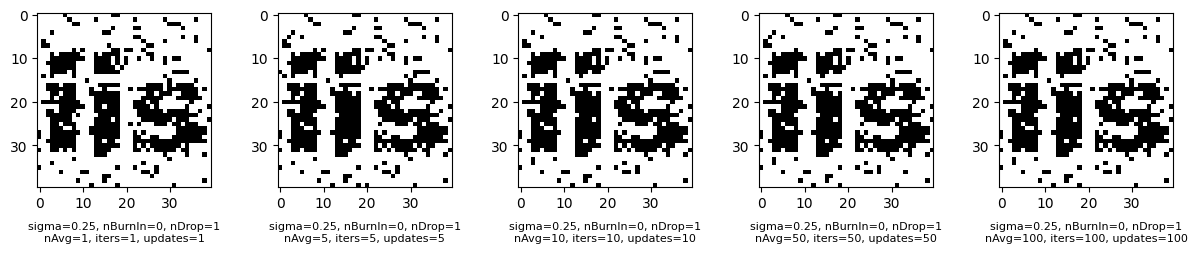

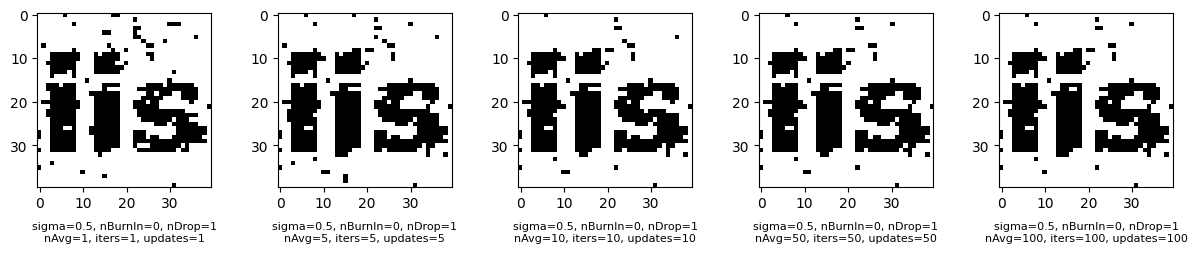

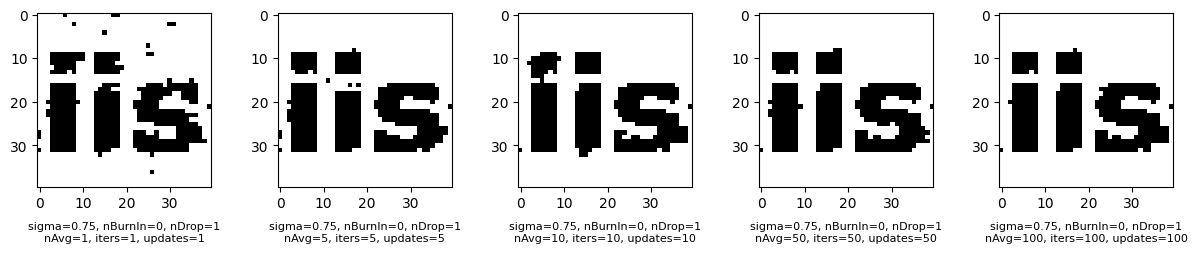

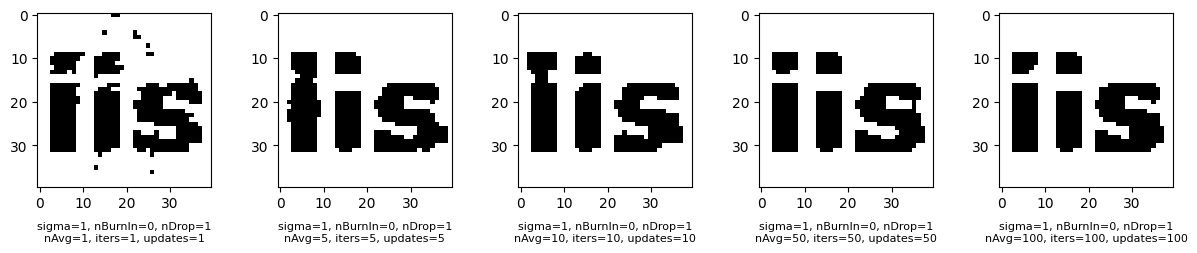

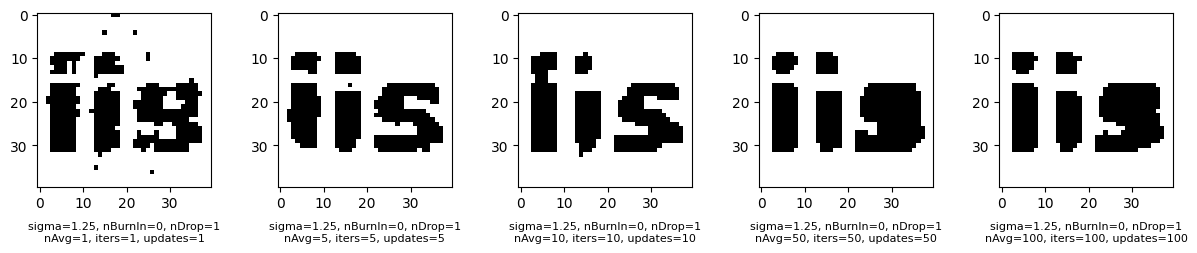

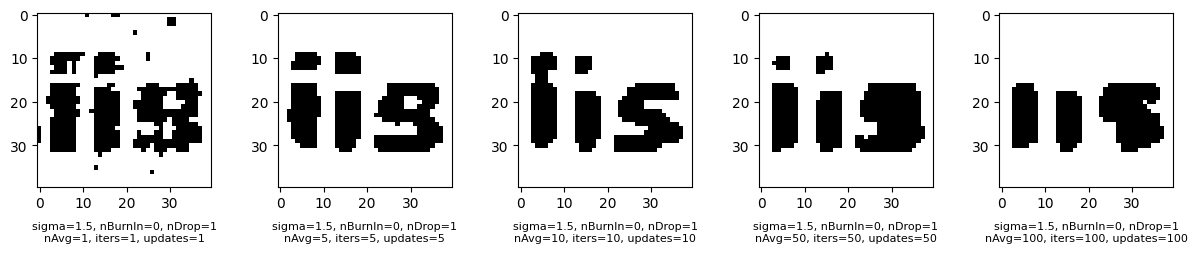

In [534]:
run_experiment(imgNoisy, sigmas=[0.25]*5, nBurnIns=[0]*5, nDrops=[1]*5, nAvgs=[1, 5, 10, 50, 100])
run_experiment(imgNoisy, sigmas=[0.5]*5, nBurnIns=[0]*5, nDrops=[1]*5, nAvgs=[1, 5, 10, 50, 100])
run_experiment(imgNoisy, sigmas=[0.75]*5, nBurnIns=[0]*5, nDrops=[1]*5, nAvgs=[1, 5, 10, 50, 100])
run_experiment(imgNoisy, sigmas=[1]*5, nBurnIns=[0]*5, nDrops=[1]*5, nAvgs=[1, 5, 10, 50, 100])
run_experiment(imgNoisy, sigmas=[1.25]*5, nBurnIns=[0]*5, nDrops=[1]*5, nAvgs=[1, 5, 10, 50, 100])
run_experiment(imgNoisy, sigmas=[1.5]*5, nBurnIns=[0]*5, nDrops=[1]*5, nAvgs=[1, 5, 10, 50, 100])